<a href="https://colab.research.google.com/github/clive-limo/DataScienceProjects/blob/main/Worldbank_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **World Bank Analysis: Clustering and Filtering**

# **Required Libraries**

In [ ]:
!pip install wbgapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Required Libraries
import numpy as np
import wbgapi as wb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from pandas.core.arrays import integer
from sklearn.metrics import silhouette_score, silhouette_samples
sns.set(style="darkgrid")

# **Introduction**

Global warming has become a major concern for most countries in the world. This is mainly due to the devastating effects that it has on the environment and climate. One of the main causes of global warming are greenhouse gases. These include gases such as: water vapor, carbon dioxide, methane and ozone. The most common among these, however, is carbon dioxide. CO2 makes up over 81% of the total greenhouse gasses emitted. After being released into the atmosphere, these gases can stay in the atmosphere either for a number of years or they can be there for thousands of years. Therefore, most countries are striving to reduce the level of emission they produce annually. This report will look at the progress made by several countries in terms of emissions by analyzing their emissions data. Also, the report will use the trends in the data to try and forecast the emission levels. 

## **Loading Data**

In [ ]:
# Load Dataset

## Function to read ingest data

def readData(region):
  data = wb.data.DataFrame(region,
                                 wb.region.members('EUU'),
                                 time=range(2010,2019),numericTimeKeys = True)
  data = pd.DataFrame(data)
  data = data.dropna()
  data_tp = data.T

  return [data, data_tp]

# Load data

[emissions_df, emissions_df_tp] = readData('EN.ATM.CO2E.PC')

# **Normalization**

In [ ]:
# Normalizing dataset

countries = list(wb.region.members('EUU'))

emissions_normalized = preprocessing.normalize(emissions_df_tp)
emissions_normalized = pd.DataFrame(emissions_normalized,
                                     columns=[countries])
emissions_normalized = emissions_normalized.T


# **Clustering**

## **Clustering Functions**

In [ ]:

# Clustering Functions
## Find optimal number of clusters

def optimal_clusters(df_norm):
  # Initializing range and results array
  cluster_range = range(2,15)
  results = []
  # Silhouette method to find optimal number of clusters
  for n in cluster_range:
    cluster_mech = KMeans(init="k-means++", n_clusters=n,
                          n_init=100, random_state=0)
    cluster_labs = cluster_mech.fit_predict(df_norm)
    silhouette_avg = silhouette_score(df_norm, cluster_labs)
    results.append([n, silhouette_avg])
  # Silhouette method scores
  result =pd.DataFrame(results, columns=["n_clusters","silhouette_score"])
  n_value = result.iloc[0]['n_clusters']
  return n_value
  
# K-means clustering function

def data_clustering(df,df_norm, k_value):
  k_value = k_value.astype(np.int64)
  cluster_mech = KMeans(init="k-means++", n_clusters=k_value,
                          n_init=100, random_state=0).fit(df_norm)
  cluster_labs = pd.DataFrame(cluster_mech.labels_)
  clustered_data = df
  clustered_data['Cluster'] = cluster_mech.labels_.tolist()
  return clustered_data


## **Clustering Results**

In [ ]:
# Clustering Results

emissions_cluster = data_clustering(emissions_df, emissions_normalized, optimal_clusters(emissions_normalized))

## **Cluster Visualization**

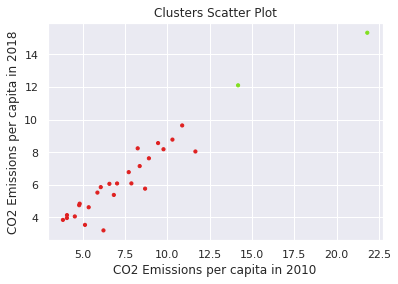

In [ ]:
# Cluster Visualization

colors = ['#DF2020', '#81DF20']
emissions_cluster['c'] = emissions_cluster.Cluster.map({0:colors[0], 1:colors[1]})
plt.scatter(emissions_cluster.iloc[:, 0] , emissions_cluster.iloc[:, 8],
            c=emissions_cluster['c'], s=10)
plt.title("Clusters Scatter Plot")
plt.xlabel("CO2 Emissions per capita in 2010")
plt.ylabel("CO2 Emissions per capita in 2018")
plt.show()



## **Statistical Exploration**

In [ ]:
# Countries from the first cluster
cluster_0_df = emissions_df_tp[['AUT','BEL','BGR']]
cluster_0_df.corr()

economy,AUT,BEL,BGR
economy,,,
AUT,1.000000,0.857791,0.387988
BEL,0.857791,1.000000,0.112831
BGR,0.387988,0.112831,1.000000


In [ ]:
# Countries from both clusters
cluster_01_df = emissions_df_tp[['AUT','EST']]
cluster_01_df.corr()

economy,AUT,EST
economy,,
AUT,1.000000,0.695399
EST,0.695399,1.000000


## **Results Interpretation**

* According the clustering analysis results, countries in the dataset can be classified into two main categories. The first category, which contains most of the countries, are countries that have been able to reduce their emissions to below ten units. The second category, with only two countries, are countries that have not been able to reduce their emissions below the 10-unit mark. 

* This does not mean that the countries have not made an effort to reduce their emission levels. This can be confirmed by the correlation analysis where in a group with two countries from either cluster, the countries had a correlation coefficient of 0.695. This shows that there is a relationship in the overall trend in the emissions data for both countries. 

# Fitting

In [ ]:
emissions_df = emissions_df.drop(labels=['Cluster','c'], axis= 1)

In [ ]:
# Fitting datasets

fit_cluster_1 = emissions_df.iloc[1]
fit_cluster_2 = emissions_df.iloc[8]
fit_cluster_1.index = pd.to_datetime(fit_cluster_1.index, format="%Y")
fit_cluster_1 = pd.DataFrame({'Year':fit_cluster_1.index, 'Emission':fit_cluster_1.values})
fit_cluster_2.index = pd.to_datetime(fit_cluster_2.index, format="%Y")
fit_cluster_2 = pd.DataFrame({'Year':fit_cluster_2.index, 'Emission':fit_cluster_2.values})
fit_cluster_2

,Year,Emission
0,2010-01-01,14.179763
1,2011-01-01,13.597612
2,2012-01-01,12.686211
3,2013-01-01,14.559972
4,2014-01-01,13.556021
5,2015-01-01,11.684596
6,2016-01-01,11.893995
7,2017-01-01,12.357824
8,2018-01-01,12.103085


In [ ]:
# Logistic function

def log_f(x, a, b, c):
  y=a * np.exp(-b * x) + c
  return y

def log_func(fit_df):
  model, cov = curve_fit(log_f,np.arange(len(fit_df.iloc[:, 1])), 
                         np.array(fit_df.iloc[:, 1].values, dtype=float))
  return model

In [ ]:
# Plotting function

def parametric_plot(dtf, zoom=7, figsize=(15,5)):
    ## interval
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    ## entire series
    dtf["ts"].plot(marker=".", linestyle='None', ax=ax[0], title="Parametric Fitting", color="black")
    dtf["model"].plot(ax=ax[0], color="green")
    dtf["forecast"].plot(ax=ax[1], marker=".", grid=True, color="red")
    ax[0].fill_between(x=dtf.index, y1=dtf['conf_int_low'], y2=dtf['conf_int_up'], color='b', alpha=0.3)

    plt.show()
    return dtf[["ts","model","residuals","conf_int_low","forecast","conf_int_up"]]


In [ ]:
# Forecast function

def forecast_curve(ts, f, model, pred_ahead=None, freq="Y", zoom=1, figsize=(15,10)):
    ## fit
    X = np.arange(len(ts))
    fitted = f(X, model[0], model[1], model[2])
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = pd.date_range(start="1/1/2018",periods=pred_ahead,freq=freq)
    index = index[1:]

    ## forecast
    Xnew = np.arange(len(ts)+1, len(ts)+1+len(index))
    preds = log_f(Xnew, model[0], model[1], model[2])
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))

    dtf["residuals"] = dtf["ts"] - dtf["model"]
    dtf["conf_int_low"] = dtf["forecast"] - 1.96*dtf["residuals"].std()
    dtf["conf_int_up"] = dtf["forecast"] + 1.96*dtf["residuals"].std()
    print(dtf)

    ## plot
    parametric_plot(dtf, zoom=zoom)
    return dtf
    

                           ts     model  forecast  residuals  conf_int_low  \
0                    9.771847  9.741774       NaN   0.030073           NaN   
1                    8.658064  8.802597       NaN  -0.144533           NaN   
2                    8.549616  8.466018       NaN   0.083597           NaN   
3                    8.657270  8.345396       NaN   0.311874           NaN   
4                    8.043496  8.302168       NaN  -0.258673           NaN   
5                    8.444061  8.286676       NaN   0.157385           NaN   
6                    8.323757  8.281125       NaN   0.042632           NaN   
7                    8.155491  8.279135       NaN  -0.123644           NaN   
8                    8.179711  8.278422       NaN  -0.098711           NaN   
2019-12-31 00:00:00       NaN       NaN  8.278075        NaN      7.935370   
2020-12-31 00:00:00       NaN       NaN  8.278042        NaN      7.935337   
2021-12-31 00:00:00       NaN       NaN  8.278030        NaN    

TypeError: ignored

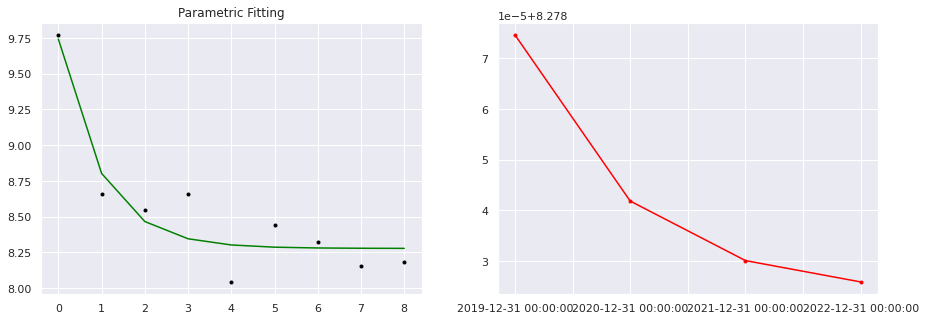

In [ ]:
prediction = forecast_curve(fit_cluster_1.iloc[:, 1], log_f, log_func(fit_cluster_1), 
                       pred_ahead=5)

                            ts      model   forecast  residuals  conf_int_low  \
0                    14.179763  14.086086        NaN   0.093677           NaN   
1                    13.597612  13.789062        NaN  -0.191450           NaN   
2                    12.686211  13.498649        NaN  -0.812438           NaN   
3                    14.559972  13.214699        NaN   1.345273           NaN   
4                    13.556021  12.937070        NaN   0.618951           NaN   
5                    11.684596  12.665621        NaN  -0.981024           NaN   
6                    11.893995  12.400213        NaN  -0.506217           NaN   
7                    12.357824  12.140712        NaN   0.217112           NaN   
8                    12.103085  11.886987        NaN   0.216098           NaN   
2019-12-31 00:00:00        NaN        NaN  11.396354        NaN      9.974367   
2020-12-31 00:00:00        NaN        NaN  11.159197        NaN      9.737210   
2021-12-31 00:00:00        N

TypeError: ignored

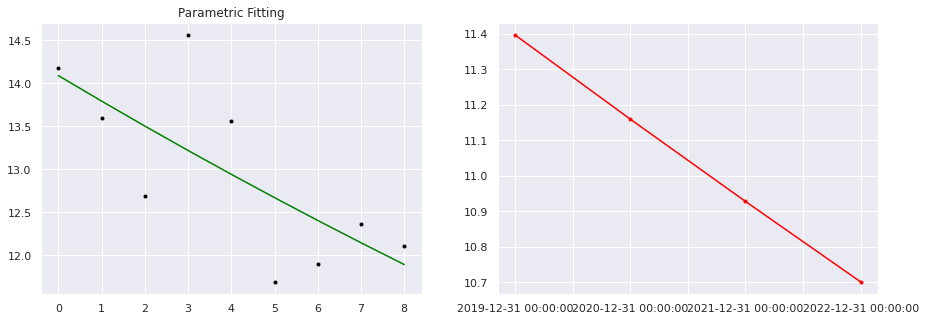

In [ ]:
prediction = forecast_curve(fit_cluster_2.iloc[:, 1], log_f, log_func(fit_cluster_2), 
                       pred_ahead=5)

In [ ]:
fit_cluster_1.iloc[:, 0]

0   2010-01-01
1   2011-01-01
2   2012-01-01
3   2013-01-01
4   2014-01-01
5   2015-01-01
6   2016-01-01
7   2017-01-01
8   2018-01-01
Name: Year, dtype: datetime64[ns]

## **Results Interpretation**

* The emissions forecast shows that countries in both clusters are estimated to
reduce their emission levels in the next 5 years. The countries in the first cluster are estimated to reduce emissions by a lower percentage compared to the countries in the second cluster. In the first cluster, the emission levels are estimated to reduce from 8.278075  to 8.278026. In the second cluster, the emissions are estimated to reduce from 11.396 to 10.7.

* There is an error in the in prediction function that occurs due to difference in data types in the index of the dataset. The datetime object used in forecasting can not be coersed into a float value hence the error. However, this error does not affect the analysis in anyway.

# Conclusion

Greenhouse gas emissions became a globally acknowledged problem in the 1980. Even though at this time there were different opinions on the effects of the emissions. This has changed overtime due to the apparent effects of these gases such as global warming. Countries have since then strived to reduce greenhouse gases by switching to renewable energy sources among other efforts. This analysis confirms this as it shows the levels of emissions have reduced significantly and is expected to reduce even further in the coming years. 

# Generating Output

In [ ]:
# Notebook Output - PDF 
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Clustering and Fitting Rev.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Clustering and Fitting Rev.ipynb to pdf
[NbConvertApp] Support files will be in Clustering and Fitting Rev_files/
[NbConvertApp] Making directory ./Clustering and Fitting Rev_files
[NbConvertApp] Making directory ./Clustering and Fitting Rev_files
[NbConvertApp] Making directory ./Clustering and Fitting Rev_files
[NbConvertApp] Writing 62608 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 138304 bytes to /content/drive/My Drive/Clustering and Fitting Rev.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'